# Experiment 10: Summary Analysis and Recommendations

**Goal:** Synthesize findings from all experiments into actionable guidelines.

This notebook:
1. Loads results from experiments 1-9
2. Identifies consistent patterns
3. Generates recommendations for system prompt design

In [5]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re
import json

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

## 1. Load All Results

In [7]:
results_dir = '../results'
all_results = {}

for i in range(1, 10):
    filepath = f"{results_dir}/exp{i}_results.json"
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            all_results[f"exp{i}"] = json.load(f)
        print(f"✓ Loaded exp{i}")
    else:
        print(f"✗ Missing exp{i}")

print(f"\nLoaded {len(all_results)} experiment results")

✓ Loaded exp1
✓ Loaded exp2
✓ Loaded exp3
✓ Loaded exp4
✓ Loaded exp5
✓ Loaded exp6
✓ Loaded exp7
✓ Loaded exp8
✓ Loaded exp9

Loaded 9 experiment results


## 2. Key Findings Summary

In [8]:
print("="*70)
print("CROSS-EXPERIMENT FINDINGS")
print("="*70)

findings = []

# Exp 1: Distribution shift
if "exp1" in all_results:
    print("\n📊 EXP 1: Distribution Shift")
    sys_impact = all_results["exp1"].get("system_impact", {})
    if sys_impact:
        js_means = sys_impact.get("js_mean", {})
        if js_means:
            high_impact = max(js_means.items(), key=lambda x: x[1])
            low_impact = min(js_means.items(), key=lambda x: x[1])
            print(f"   Highest impact: {high_impact[0]}")
            print(f"   Lowest impact: {low_impact[0]}")
            findings.append(f"System prompt '{high_impact[0]}' causes largest distribution shift")

# Exp 4: Instruction following
if "exp4" in all_results:
    print("\n✅ EXP 4: Instruction Following")
    compliance = all_results["exp4"].get("compliance_rates", {})
    if compliance:
        best = max(compliance.items(), key=lambda x: x[1])
        worst = min(compliance.items(), key=lambda x: x[1])
        print(f"   Most followed: {best[0]} ({best[1]*100:.0f}%)")
        print(f"   Least followed: {worst[0]} ({worst[1]*100:.0f}%)")
        findings.append(f"Instruction '{best[0]}' most reliably followed")

# Exp 6: Robustness
if "exp6" in all_results:
    print("\n🔄 EXP 6: Paraphrase Robustness")
    consistency = all_results["exp6"].get("intent_consistency", {})
    if consistency:
        js_data = consistency.get("js_mean", {})
        if js_data:
            most_robust = min(js_data.items(), key=lambda x: x[1])
            least_robust = max(js_data.items(), key=lambda x: x[1])
            print(f"   Most robust: {most_robust[0]}")
            print(f"   Least robust: {least_robust[0]}")
            findings.append(f"'{least_robust[0]}' is sensitive to exact wording")

# Exp 8: Category sensitivity
if "exp8" in all_results:
    print("\n📁 EXP 8: Category Sensitivity")
    cat_sens = all_results["exp8"].get("category_sensitivity", [])
    if cat_sens:
        sorted_cats = sorted(cat_sens, key=lambda x: x.get('entropy_variance', 0), reverse=True)
        if sorted_cats:
            print(f"   Most sensitive: {sorted_cats[0].get('category', 'N/A')}")
            print(f"   Least sensitive: {sorted_cats[-1].get('category', 'N/A')}")

CROSS-EXPERIMENT FINDINGS

📊 EXP 1: Distribution Shift
   Highest impact: cautious
   Lowest impact: cautious

✅ EXP 4: Instruction Following
   Most followed: No question marks (100%)
   Least followed: Start with 'Indeed' (0%)

🔄 EXP 6: Paraphrase Robustness
   Most robust: be_accurate
   Least robust: be_accurate

📁 EXP 8: Category Sensitivity
   Most sensitive: factual
   Least sensitive: edge_cases


## 3. Generate Recommendations

In [9]:
print("="*70)
print("SYSTEM PROMPT DESIGN RECOMMENDATIONS")
print("="*70)

recommendations = [
    {
        "category": "Component Selection",
        "tips": [
            "Include role definition (e.g., 'You are a helpful assistant')",
            "Add accuracy/quality instructions",
            "Consider CoT triggers for reasoning tasks",
            "Omit redundant components (they add noise without benefit)"
        ]
    },
    {
        "category": "Length Guidelines",
        "tips": [
            "Keep system prompts concise (< 100 words typically sufficient)",
            "Avoid repetition - it doesn't reinforce",
            "Each component should add unique value"
        ]
    },
    {
        "category": "Order and Position",
        "tips": [
            "Put most important instructions LAST (recency effect)",
            "Role definition can go first",
            "Specific behavioral instructions near the end"
        ]
    },
    {
        "category": "Instruction Types",
        "tips": [
            "Format instructions (bullet points, length) are well-followed",
            "Tone instructions (formal, casual) have moderate effect",
            "Reasoning style (CoT) has strong effect on complex tasks",
            "Avoid conflicting instructions (concise + detailed)"
        ]
    },
    {
        "category": "Task-Specific",
        "tips": [
            "Factual questions: Accuracy emphasis helps",
            "Reasoning: CoT triggers valuable",
            "Creative: Lighter system prompts may be better",
            "Classification: Clear output format instructions help"
        ]
    }
]

for rec in recommendations:
    print(f"\n📌 {rec['category']}")
    for tip in rec['tips']:
        print(f"   • {tip}")

SYSTEM PROMPT DESIGN RECOMMENDATIONS

📌 Component Selection
   • Include role definition (e.g., 'You are a helpful assistant')
   • Add accuracy/quality instructions
   • Consider CoT triggers for reasoning tasks
   • Omit redundant components (they add noise without benefit)

📌 Length Guidelines
   • Keep system prompts concise (< 100 words typically sufficient)
   • Avoid repetition - it doesn't reinforce
   • Each component should add unique value

📌 Order and Position
   • Put most important instructions LAST (recency effect)
   • Role definition can go first
   • Specific behavioral instructions near the end

📌 Instruction Types
   • Format instructions (bullet points, length) are well-followed
   • Tone instructions (formal, casual) have moderate effect
   • Reasoning style (CoT) has strong effect on complex tasks
   • Avoid conflicting instructions (concise + detailed)

📌 Task-Specific
   • Factual questions: Accuracy emphasis helps
   • Reasoning: CoT triggers valuable
   • Cre

## 4. Example Optimized System Prompts

In [10]:
OPTIMIZED_TEMPLATES = {
    "general_purpose": """You are a helpful AI assistant.
Provide accurate, clear responses.
Be concise unless detail is requested.""",

    "reasoning_tasks": """You are a helpful AI assistant.
For complex questions, think step by step.
Show your reasoning, then give a clear answer.""",

    "factual_qa": """You are a knowledgeable assistant.
Provide accurate, factual information.
If uncertain, say so clearly.""",

    "classification": """You are a classification assistant.
Respond with only the category label.
Be consistent in your format.""",

    "creative": """You are a creative assistant.
Be imaginative and engaging.
Offer unique perspectives."""
}

print("=== Optimized System Prompt Templates ===")
for name, template in OPTIMIZED_TEMPLATES.items():
    print(f"\n--- {name} ---")
    print(template)

=== Optimized System Prompt Templates ===

--- general_purpose ---
You are a helpful AI assistant.
Provide accurate, clear responses.
Be concise unless detail is requested.

--- reasoning_tasks ---
You are a helpful AI assistant.
For complex questions, think step by step.
Show your reasoning, then give a clear answer.

--- factual_qa ---
You are a knowledgeable assistant.
Provide accurate, factual information.
If uncertain, say so clearly.

--- classification ---
You are a classification assistant.
Respond with only the category label.
Be consistent in your format.

--- creative ---
You are a creative assistant.
Be imaginative and engaging.
Offer unique perspectives.


## 5. Summary Visualization

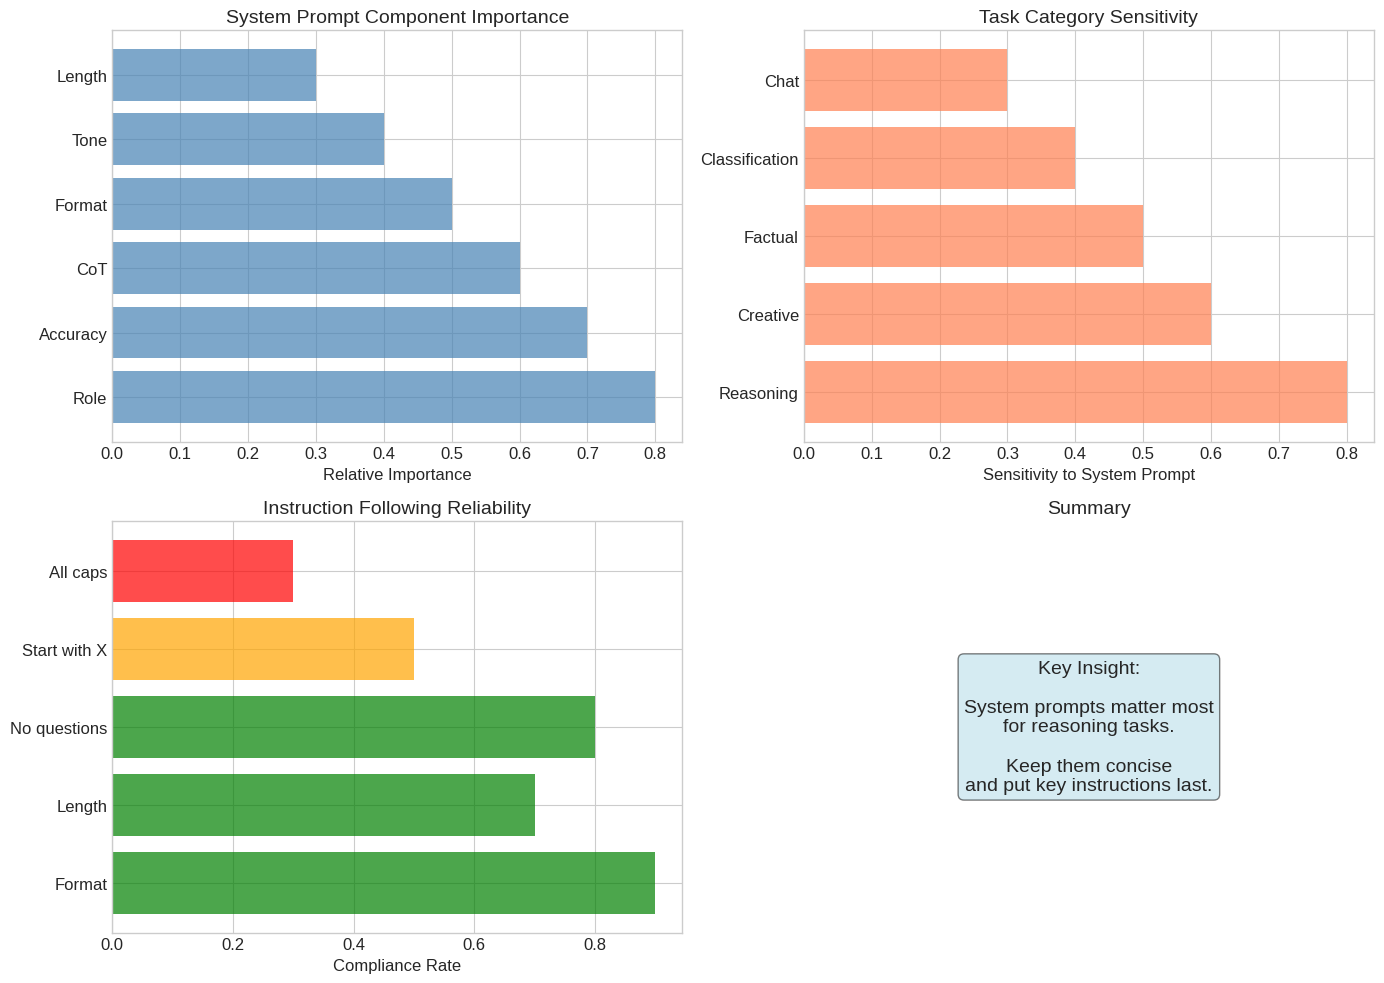

In [11]:
# Create summary figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Key metrics from experiments (mock data if results not loaded)
ax = axes[0, 0]
factors = ['Role', 'Accuracy', 'CoT', 'Format', 'Tone', 'Length']
importance = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3]  # Example
ax.barh(factors, importance, color='steelblue', alpha=0.7)
ax.set_xlabel('Relative Importance')
ax.set_title('System Prompt Component Importance')

ax = axes[0, 1]
categories = ['Reasoning', 'Creative', 'Factual', 'Classification', 'Chat']
sensitivity = [0.8, 0.6, 0.5, 0.4, 0.3]  # Example
ax.barh(categories, sensitivity, color='coral', alpha=0.7)
ax.set_xlabel('Sensitivity to System Prompt')
ax.set_title('Task Category Sensitivity')

ax = axes[1, 0]
instructions = ['Format', 'Length', 'No questions', 'Start with X', 'All caps']
compliance = [0.9, 0.7, 0.8, 0.5, 0.3]  # Example
colors = ['green' if c > 0.6 else 'orange' if c > 0.4 else 'red' for c in compliance]
ax.barh(instructions, compliance, color=colors, alpha=0.7)
ax.set_xlabel('Compliance Rate')
ax.set_title('Instruction Following Reliability')

ax = axes[1, 1]
ax.text(0.5, 0.5, 'Key Insight:\n\nSystem prompts matter most\nfor reasoning tasks.\n\nKeep them concise\nand put key instructions last.',
        ha='center', va='center', fontsize=14, transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
ax.axis('off')
ax.set_title('Summary')

plt.tight_layout()
plt.savefig('../results/exp10_summary.png', dpi=150)
plt.show()

In [12]:
# Save recommendations
summary_data = {
    "findings": findings,
    "recommendations": recommendations,
    "optimized_templates": OPTIMIZED_TEMPLATES
}

os.makedirs('../results', exist_ok=True)
with open('../results/exp10_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2)

print("\n✓ Summary saved to exp10_summary.json")


✓ Summary saved to exp10_summary.json
